In [ ]:
!pip install lime -q
!pip install tensorflow -q

In [8]:
import pandas as pd
import numpy as np
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Interpretation

Understanding and diagnosing your machine-learning models - Gaël Varoquaux - [youtube](https://youtu.be/kbj3llSbaVA)

In [9]:
url = 'http://lib.stat.cmu.edu/datasets/CPS_85_Wages'

cols = [
'EDUCATION: Number of years of education.',
'SOUTH: Indicator variable for Southern Region (1=Person lives in 		South, 0=Person lives elsewhere).',
'SEX: Indicator variable for sex (1=Female, 0=Male).',
'EXPERIENCE: Number of years of work experience.',
'UNION: Indicator variable for union membership (1=Union member, 		0=Not union member).',
'WAGE: Wage (dollars per hour).',
'AGE: Age (years).',
'RACE: Race (1=Other, 2=Hispanic, 3=White).',
'OCCUPATION: Occupational category (1=Management, 		2=Sales, 3=Clerical, 4=Service, 5=Professional, 6=Other).',
'SECTOR: Sector (0=Other, 1=Manufacturing, 2=Construction).',
'MARR: Marital Status (0=Unmarried,  1=Married)'
]

In [10]:
raw = pd.read_csv(url, skiprows=27, skipfooter=6, sep=None, header=None)

raw.columns = [c.split(':')[0].lower() for c in cols]

raw.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,education,south,sex,experience,union,wage,age,race,occupation,sector,marr
0,8,0,1,21,0,5.10,35,2,6,1,1
1,9,0,1,42,0,4.95,57,3,6,1,1
2,12,0,0,1,0,6.67,19,3,6,1,0
3,12,0,0,4,0,4.00,22,3,6,0,0
4,12,0,0,17,0,7.50,35,3,6,0,1


Log-transform to deal with multiplicative factors (also makes more normal):

In [11]:
data = raw.copy()

data.loc[:, 'y'] = np.log10(data.loc[:, 'wage'])

## What do you see below?

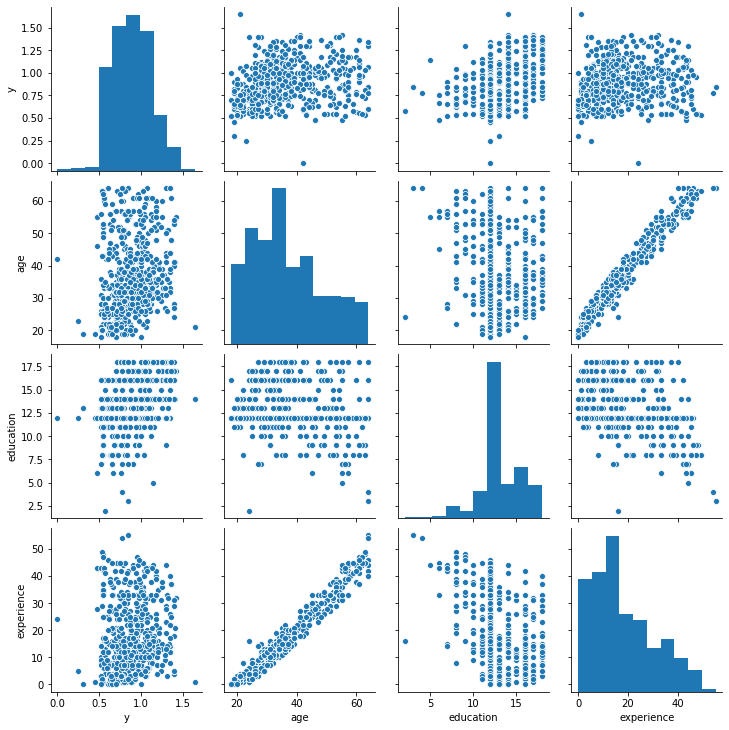

In [12]:
import seaborn as sns
sns.pairplot(data, vars=['y', 'age', 'education', 'experience'])

## LIME

[marcotcr/lime](https://github.com/marcotcr/lime) - explores linear, local decision boundaries of features

For a linear model, interpretation is global (constant)

For non-linear models, the interpretation must be local

Explains **single predictions**
- local explanation
- local means linear is a good approximation

LIME can be used for tabular data, images and text

### LIME for NLP

[Tutorial](https://marcotcr.github.io/lime/tutorials/Lime%20-%20basic%20usage%2C%20two%20class%20case.html)

```
The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date.
```

In [14]:
cats = ['alt.atheism', 'soc.religion.christian']
tr = fetch_20newsgroups(subset='train', categories=cats)
te = fetch_20newsgroups(subset='test', categories=cats)

print(tr['target_names'])

['alt.atheism', 'soc.religion.christian']


In [15]:
enc = TfidfVectorizer(lowercase=False)
tr_vec = enc.fit_transform(tr.data)
te_vec = enc.transform(te.data)

In [16]:
tr_vec[1].todense()

matrix([[0., 0., 0., ..., 0., 0., 0.]])

Train a forest:

In [17]:
rf = RandomForestClassifier(n_estimators=200, verbose=0, n_jobs=4)
rf.fit(tr_vec, tr.target)
pred = rf.predict(te_vec)
f1_score(te.target, pred, average='weighted')

0.9048626107061326

In [18]:
c = make_pipeline(enc, rf)
print(c.predict_proba([te.data[0]]))

[[0.37 0.63]]


In [19]:
explainer = LimeTextExplainer(class_names=tr['target_names'])
idx = 56
exp = explainer.explain_instance(te.data[idx], c.predict_proba, num_features=6)
print('Document id: %d' % idx)
print('Probability(christian) =', c.predict_proba([te.data[idx]])[0,1])
print('True class: %s' % tr['target_names'][te.target[idx]])

exp.show_in_notebook(text=True)

Document id: 56
Probability(christian) = 0.77
True class: soc.religion.christian
